# Pattern Recognition - Tarea 2 - Automatic Segmentation

## Introduction

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import sklearn
import pandas as pd
import os
from skimage import io
from skimage.color import rgb2gray
import scipy
from scipy.signal import convolve2d

# ML classification
from sklearn.ensemble import RandomForestClassifier

We are firstly going to read all images.

In [39]:
# estagblishing the paths
img_path = "/home/osboxes/Documents/python/recpatr/auto-segmentation/"
img_path = "/u/a/2019/apoupeau/Documentos/recpatr/auto-segmentation"
img_raw_path = os.path.join(img_path, "datos_tarea2/raw.tif")
img_seg_path = os.path.join(img_path, "datos_tarea2/segmentacion_referencia.tif")

# getting raw and ground truth data
raw_data = io.imread(img_raw_path)
seg_data = np.array((1/255) * io.imread(img_seg_path), dtype=int) # class 0 : 255 => to 0 : 1

# get info 55 images of shape 512x512
print(raw_data.shape)
print(seg_data.shape)

print("min-max values raw :", np.min(raw_data), np.max(raw_data))
print("min-max values seg :", np.min(seg_data), np.max(seg_data))

(55, 512, 512)
(55, 512, 512)
min-max values raw : 1 255
min-max values seg : 0 1


Create some tools functions like display an image.

## Convolution 

We want to extract caracteristics from each images. In order to do that we will first create three kernels (filters) and a function that make the convolution. 

http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html

In [3]:
# KERNELS
mean_kernel = 1/9 * np.ones(shape=(3,3))

sobelx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]])

sobely_kernel = np.array([[-1, -2, -1],
                          [0, 0, 0],
                          [1, 2, 1]])

laplacian_kernel = np.array([[-1, -1, -1],
                             [-1,  8, -1],
                             [-1, -1, -1]])

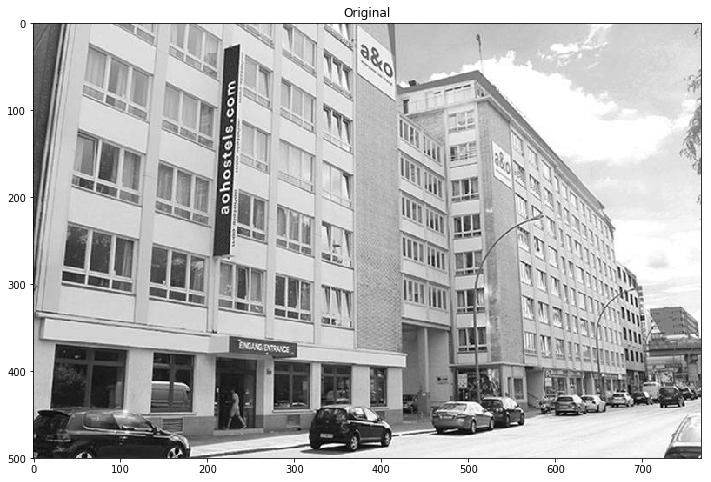

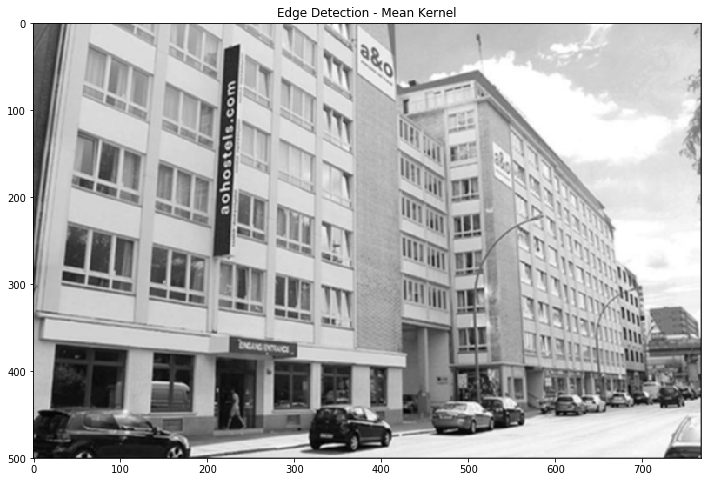

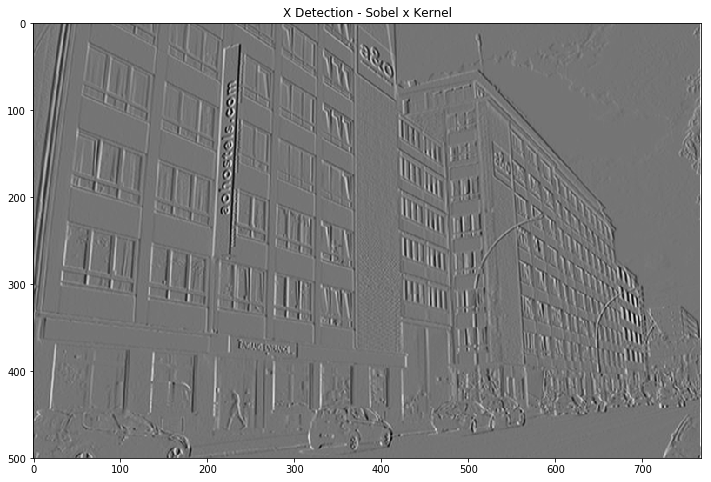

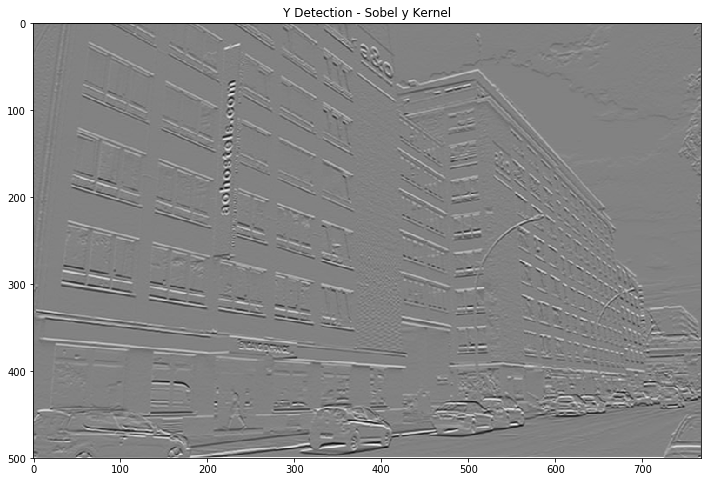

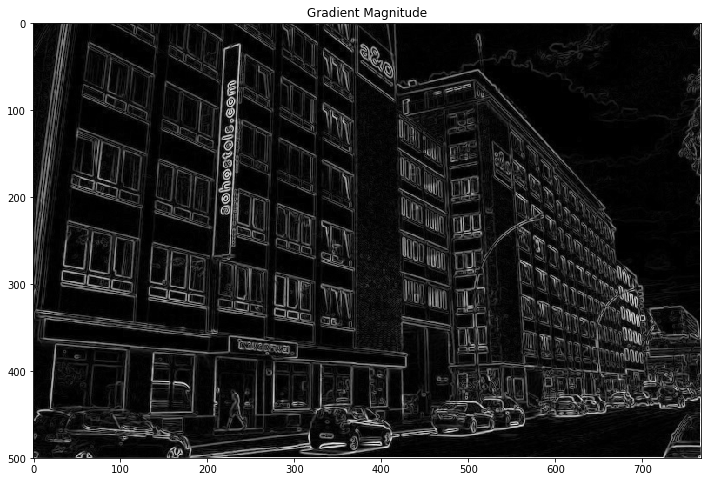

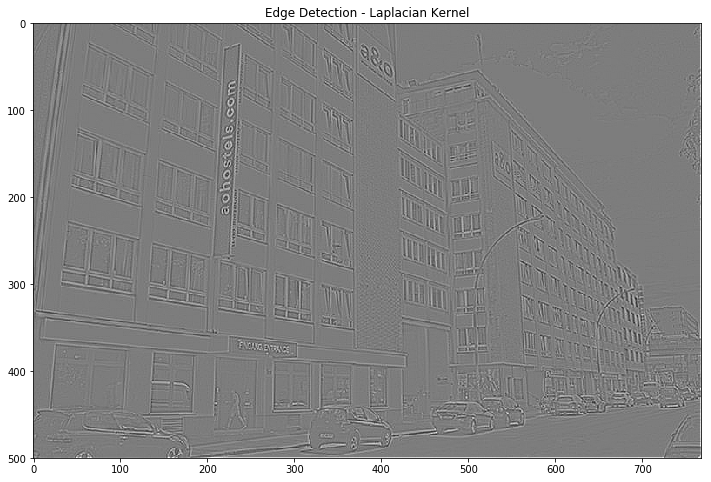

In [12]:
test_img = io.imread(os.path.join(img_path, "img/building.jpg"))
# test_img = io.imread(os.path.join(img_path, "img/chair.jpg"))
# test_img = raw_data[0]
test_img = rgb2gray(test_img)

# original img
plt.figure(figsize=(14,8))
plt.title("Original")
plt.imshow(test_img, cmap="gray")
plt.show()

# mean kernel
trans_img = convolve2d(test_img, mean_kernel, "same")
plt.figure(figsize=(14,8))
plt.title("Edge Detection - Mean Kernel")
plt.imshow(trans_img, cmap="gray")
plt.show()

# sobelx kernel
transx_img = convolve2d(test_img, sobelx_kernel, "same")
plt.figure(figsize=(14,8))
plt.title("X Detection - Sobel x Kernel")
plt.imshow(transx_img, cmap="gray")
plt.show()

# sobely kernel
transy_img = convolve2d(test_img, sobely_kernel, "same")
plt.figure(figsize=(14,8))
plt.title("Y Detection - Sobel y Kernel")
plt.imshow(transy_img, cmap="gray")
plt.show()

# gradient magnitud
grad_mag = np.sqrt(transx_img**2 + transy_img**2)
plt.figure(figsize=(14,8))
plt.title("Gradient Magnitude")
plt.imshow(grad_mag, cmap="gray")
plt.show()

# laplacian kernel
trans_img = convolve2d(test_img, laplacian_kernel, "same")
plt.figure(figsize=(14,8))
plt.title("Edge Detection - Laplacian Kernel")
plt.imshow(trans_img, cmap="gray")
plt.show()

## Extract features

We have to extract the three features per pixel for each image. The function thus takes as an input an image of shape (512x512) and returns three "modified" images which shape is equal to (512x512).

In [49]:
def extractFeatures(img):
    """
        Compute three features : mean, magnitud and edge detection.
        
        Arguments:
            img (array) : shape (512,512)
        
        Return:
            features (array) : shape (3,512,512)
    """
    # mean kernel
    blurred_img = convolve2d(img, mean_kernel, "same")
    
    # gradient magnitud
    transx_img = convolve2d(img, sobelx_kernel, "same")
    transy_img = convolve2d(img, sobely_kernel, "same")
    grad_mag = np.sqrt(transx_img**2 + transy_img**2)

    # laplacian kernel
    lap_img = convolve2d(img, laplacian_kernel, "same")
    
    # concatenate
    features = np.array([blurred_img, grad_mag, lap_img])
    
    return features

In [50]:
# test
extractFeatures(raw_data[0]).shape

(3, 512, 512)

In [67]:
def linkImgFeaturesAndClass(img, class_pixels_img):
    """
        Arguments:
            img (array) : raw image (512,512)
            class_pixels_img (array) : values 0 or 1 in it, class for each pixel of the img
        
        Return:
            features_and_class (array) : shape (512*512, 4)
    """
    # extract features
    features_img = extractFeatures(img=img)
    
    # get dataset for the current img
    shp = features_img.shape
    flatten_features_img = np.zeros(shape=(4, shp[-1]**2))
    for i, feature in enumerate(features_img):
        flatten_features_img[i] = feature.flatten()
    
    # concatenate class_pixels_img and features
    flatten_features_img[-1] = class_pixels_img.flatten()
    features_and_class = flatten_features_img.T
    
    return features_and_class

In [73]:
# test ok
linkImgFeaturesAndClass(raw_data[0], seg_data[0]).shape

(262144, 4)

In [ ]:
def computeDataset(X, y):
    """
        X (array) : all raw images
        y (array) : label for all pixel
    """

## Segmentation

Now we are going to classify use the ground truth data we have in the file segmentacion_referencia.tif.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,